# Shlukovací metriky

Shlukovací algoritmy jsou typickým zástupcem strojového učení bez učitele, což ve výsledku znamená, že v praxi nemáme možnost porovnat výsledky modelu se známou správnou hodnotou, protože takové hodnoty nemáme k dispozici. Přesto existuje hned několik způsobů, jak se o kvalitě výsledků shlukování přesvědčit a jak těchto metrik využít ke správnému nastavení modelů.

> Existují i tzv. externí metriky, které ke svému fungování potřebují znát skutečnou příslušnost individuí ke shlukům, ale těmi se dnes zabývat nebudeme a zkusíme zůstat u skutečného učení bez učitele.

## Před samotným shlukováním

Ještě než se pustíme do shlukování a validace výsledků, je dobré se přesvědčit, že naše data jsou k tomuto zpracování vhodná. Datová sada, kde jsou jednotlivá individua rozeseta rovnoměrně bez jakékoli tendence ke tvorbě shluků, dá zabrat i těm nejlepším shlukovacím algoritmům a výsledek bude k ničemu.

### Hopkins test

Hopkins test nám usnadní jednoduchým výpočtem zjistit, zda je dataset vhodný pro shlukovací analýzu. Jeho nulová hypotéza říká: *„Datové záznamy mají nenáhodnou rovnoměrnou distribuci“* — což ve výsledku znamená, že nějaké smysluplné shluky bychom v takových datech hledali jen těžko. Alternativní hypotéza říká: *„Datové záznamy jsou generovány náhodně“* a tedy je možné očekávat shluky.

Hopkins test bohužel není implementován přímo ve scikit-learn, ale jeho implementace je i tak v Pythonu dostupná v balíčku pyclustertend.

> Bohužel, poslední verze vydaná na PyPI nefunguje s poslední verzí scikit-learn kvůli opravené chybě ve jméně jedné funkce. Zkuste nejdříve instalaci prvním příkazem a pokud nebude výpočet fungovat, druhý příkaz provede aktualizaci na nejnovější verzi z Githubu.

In [1]:
#%pip install pyclustertend

In [2]:
#%pip install --upgrade git+https://github.com/lachhebo/pyclustertend

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
import numpy as np

%matplotlib inline
sns.set()

Nejprve si vygenerujeme dvě datové sady, u kterých bude podstatný rozdíl v jejich připravenosti na shlukovací analýzu.

In [4]:
X_shluky, y_true = make_blobs(n_samples=500, centers=4, cluster_std=0.50, random_state=0)

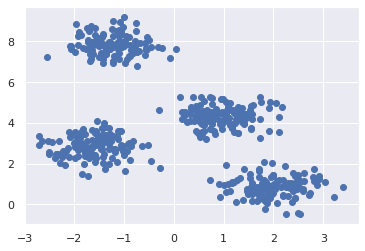

In [5]:
plt.scatter(X_shluky[:, 0], X_shluky[:, 1]);

In [6]:
X_bez_shluku = np.random.uniform(low=(0, 0), high=(4, 4), size=(500, 2))

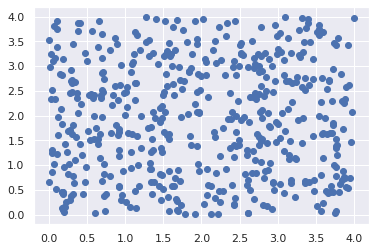

In [7]:
plt.scatter(X_bez_shluku[:, 0], X_bez_shluku[:, 1]);

In [8]:
from pyclustertend import hopkins

In [9]:
hopkins(X_shluky, sampling_size=100)

0.1431948031493256

In [10]:
hopkins(X_bez_shluku, sampling_size=100)

0.4931077721688629

Dle [dokumentace](https://pyclustertend.readthedocs.io/en/latest/#pyclustertend.hopkins.hopkins) je skóre blízké nule indikátorem existujících shluků, zatímco skóre kolem 0,5 poukazuje na jejich absenci. Mimo tuto výpočetní metodu existuje i možnost si rozložení shluků vizualizovat.

### Vizualizace

U vizualizace můžeme využít scatter_martix či pairplot pro vizualizaci všech dimenzí, nebo zkusit použít PCA a počet dimenzí nejprve redukovat na dvě či tři. pyclustertend však obsahuje ještě další metodu zvanou VAT (visual assessment of tendency). VAT vytvoří vizualizaci vzdáleností jednotlivých záznamů a zobrazí je jako barevnou matici. Čím blíže je barva černé, tím menší vzdálenost mezi individui je. Z obrázku lze tedy vyčíst pravděpodobný počet clusterů a jejich hierarchii.

In [11]:
from pyclustertend import vat

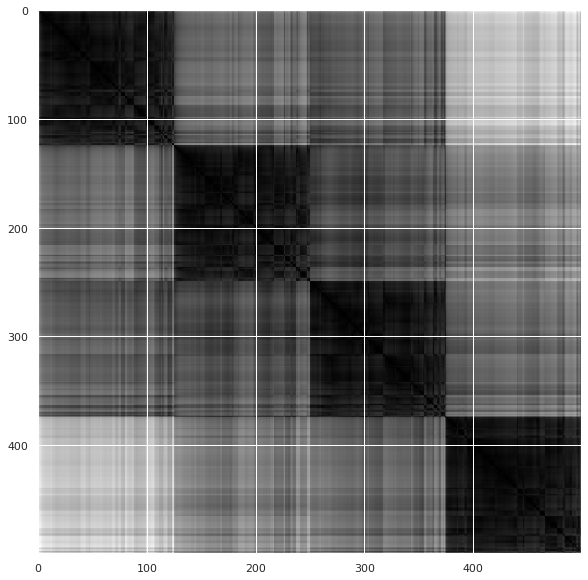

In [12]:
vat(X_shluky)

Tmavé čtverce na diagonále signalizují potencionální shluky bodů, které jsou si blíže, a změna barvy okolo nich signalizuje, jak daleko jsou od ostatních shluků.

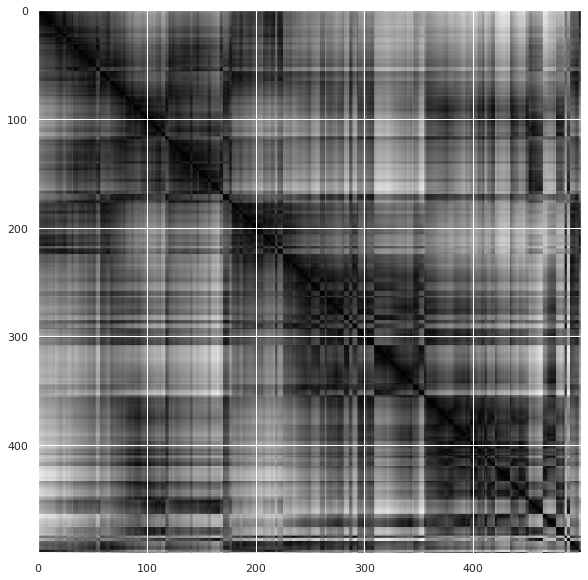

In [13]:
vat(X_bez_shluku)

Výsledek pro rovnoměrné rozložení není ani zdaleka tak slibný jako v předchozím příkladu.

## Metriky

A teď už k samotným metrikám.

### Index siluety

Index siluety je velmi snadný na výpočet a přitom velmi praktický jako metrika pro určení kvality použitého shlukování. Vypočítá se pomocí následujícího vzorce:

$$ s = \frac{b - a}{max(a, b)}$$

kde *a* je průměrná vzdálenost bodu a všech ostatních bodů ve stejném shluku a *b* je průměrná vzdálenost bodu a všech bodů v jiném nejbližším shluku. Výsledek takového výpočtu může být v intervalu <-1, 1>. 1 znamená, že bod je přiřazen ke správnému shluku, 0 jej označuje na bod na rozhraní mezi shluky a -1 značí, že by jej bylo lepší přiřadit k jinému shluku.

Zkusme si tedy tuto metriku použít společně s k-means a záměrně špatně a následně správně zvoleným počtem shluků. Výsledky si uložíme do různých proměnných a využijeme je i pro další metriky.

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from matplotlib import cm

In [15]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_shluky)
spatny_vysledek = kmeans.predict(X_shluky)

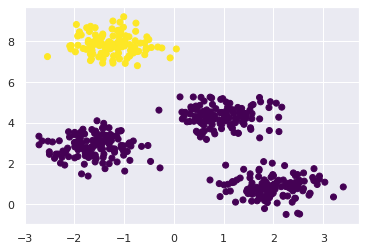

In [16]:
plt.scatter(X_shluky[:, 0], X_shluky[:, 1], c=spatny_vysledek, cmap=cm.viridis);

Vizualizace odhalila špatný výsledek, co na to index siluety?

In [17]:
silhouette_score(X_shluky, spatny_vysledek)

0.5790014232135651

Za moment tento výsledek porovnáme s výsledkem k-means se správným počtem shluků.

In [18]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_shluky)
spravny_vysledek = kmeans.predict(X_shluky)

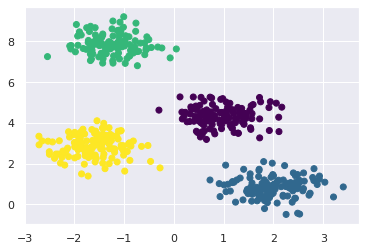

In [19]:
plt.scatter(X_shluky[:, 0], X_shluky[:, 1], c=spravny_vysledek, cmap=cm.viridis);

In [20]:
silhouette_score(X_shluky, spravny_vysledek)

0.7376648174803581

Výsledek pro správně nastavený model vyšel podstatně blíže jedné, což je jasný indikátor správného nastavení.

U indexu siluety je třeba mít na paměti fakt, že je celkem náročný na výpočet, protože počítá vzdálenosti mezi všemi body tolikrát, kolik bodů v datech máme.

### Davies-Bouldin index

Davies-Bouldin index je dán následujícím vzorcem:

$$ DB = \frac{1}{n} \sum_{i=1}^n max_{j\neq i} (\frac{o_{i} + o_{j}}{d(c_{i}, c_{j})}) $$

Kde *n* je počet clusterů, v čitateli je součet průměrných vzdáleností bodů od středů shluků a ve jmenovateli je vzdálenost mezi středy shluků.

Nízké hodnoty tohoto indexu indikují, že nalezené shluky jsou kompaktní a daleko od sebe, což značí dobrý výsledek. Opět si tuto metriku zkusíme aplikovat na testovacím příkladu se špatně a správně nastaveným modelem.

In [21]:
from sklearn.metrics import davies_bouldin_score

In [22]:
davies_bouldin_score(X_shluky, spatny_vysledek)

0.49586799774754986

In [23]:
davies_bouldin_score(X_shluky, spravny_vysledek)

0.37005467815898946

### Calinski-Harabasz index

Calinski-Harabasz index (jinak též Variance Ratio Criterion) je index porovnávající rozptyl mezi shluky k rozptylu uvnitř jednotlivých shluků, kde rozptyl je definován jako druhá mocnina sumy vzdáleností.

Tento index je rychlý na výpočet a je opět tím vyšší čím kompaktnější a dál od sebe jsou jednotlivé shluky.

In [24]:
from sklearn.metrics import calinski_harabasz_score

In [25]:
calinski_harabasz_score(X_shluky, spatny_vysledek)

742.6421176832371

In [26]:
calinski_harabasz_score(X_shluky, spravny_vysledek)

3025.8701914176518

## Využití metrik k hledání správného nastavení

Teď, když už známe některé z nejznámějších metrik pro validaci kvality shlukování, je můžeme využít pro hledání toho správného nastavení. U shlukování založeného na centroidech ale třeba také u hierarchického shlukování se nám hodí vědět, kolik shluků je v datech obsaženo. Je to sice náročnější na výpočet, ale můžeme vyzkoušet to správné číslo najít hrubou silou s pomocí metriky a více pokusů s různým nastavením.

In [27]:
si = []
db = []
ch = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_shluky)
    vysledek = kmeans.predict(X_shluky)
    
    si.append(silhouette_score(X_shluky, vysledek))
    db.append(davies_bouldin_score(X_shluky, vysledek))
    ch.append(calinski_harabasz_score(X_shluky, vysledek))

V jednotlivých seznamech máme zaznamenány výsledky jednotlivých metrik pro k-means s různým nastavením *k* od 2 do 9 shluků. Pojďme se přehledně podívat na výsledky.

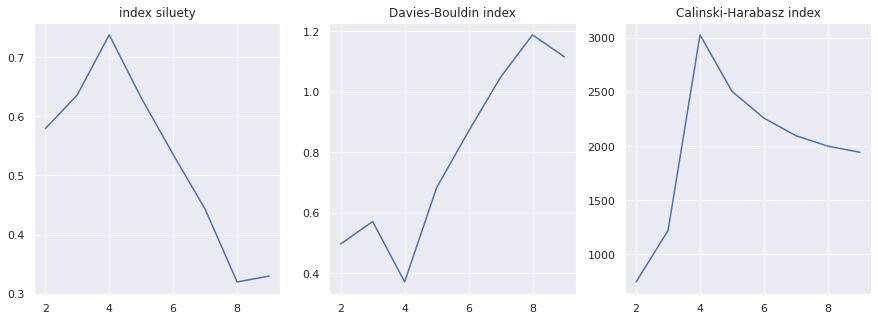

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].plot(range(2, 10), si);
ax[1].plot(range(2, 10), db);
ax[2].plot(range(2, 10), ch);
ax[0].set_title("index siluety");
ax[1].set_title("Davies-Bouldin index");
ax[2].set_title("Calinski-Harabasz index");

Jak je vidět, každá metrika nám dává různá čísla, ale všechny se shodují, že 4 je ideální nastavení pro počet hledaných shluků.

## Kosatce

Můžeme podobný experiment vyzkoušet i pro kosatce a to i s hopkinsnovým testem a VAT. Iris dataset je ovšem příkladem toho, kdy by nám k odhadu správného počtu hledaných shluků měla pomoci spíše znalost dat a domény, ve které se pohybujeme, než jen výpočty. Uvidíme, jak si slepé počítaní poradí.

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()

In [30]:
hopkins(iris.data, sampling_size=50)

0.15291796927371465

Dle Hopkinsnova testu je dataset vhodný pro shlukovací analýzu.

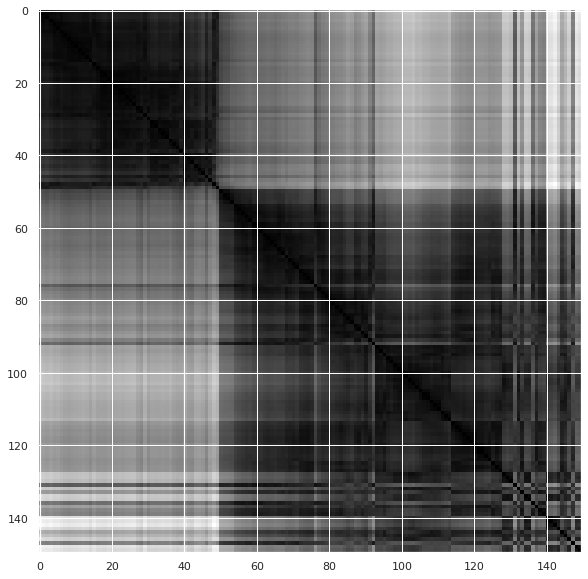

In [31]:
vat(iris.data)

Vizualizace výsledek testu potvrzuje a napovídá, že se nejspíše bude jednat o dva shluky.

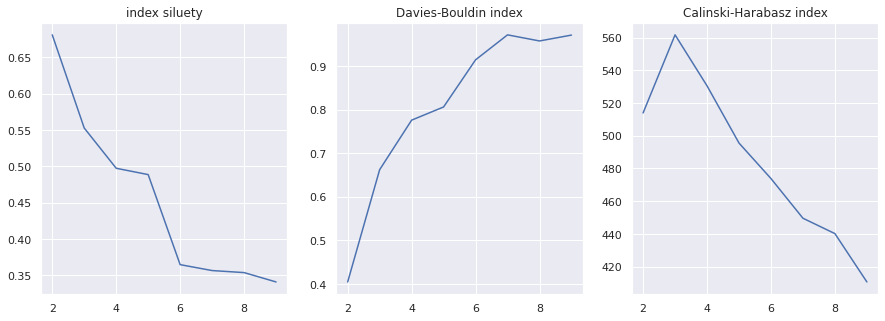

In [32]:
si = []
db = []
ch = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(iris.data)
    vysledek = kmeans.predict(iris.data)
    
    si.append(silhouette_score(iris.data, vysledek))
    db.append(davies_bouldin_score(iris.data, vysledek))
    ch.append(calinski_harabasz_score(iris.data, vysledek))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].plot(range(2, 10), si);
ax[1].plot(range(2, 10), db);
ax[2].plot(range(2, 10), ch);
ax[0].set_title("index siluety");
ax[1].set_title("Davies-Bouldin index");
ax[2].set_title("Calinski-Harabasz index");

Tady je výsledek velmi zajímavý. I když víme, že data opravdu vypadají, jako by zde byly jen dva shluky, protože druh virginica a versicolor jsou si velmi podobné, Calinski-Harabasz index jako jediný určil, že by bylo dobré hledat v datech shluky tři. Bez znalosti domény by nám toto zjištění mohlo hodně napovědět.

### Zajímavost na závěr

Je to právě funkce `calinski_harabasz_score`, která způsobila problémy. Při implementaci do scikit-learn ji totiž omylem pojmenovali `calinski_harabaz_score` a takto ji také další tvůrci, mimo jiné i tvůrce `pyclustertend`, začali používat. Při opravě ji samozřejmě nemohli hned odebrat a tak několik verzí byla dostupná obě jména a ve verzi 0.23 to staré nadobro odebrali. Vše je vidět v tomto [commitu](https://github.com/scikit-learn/scikit-learn/commit/dc883c7d9e64bd78854c63435c666af880043d76).

Tvůrce `pyclustertend` na to zareagoval a jméno funkce také [opravil](https://github.com/lachhebo/pyclustertend/commit/be0eefcb3d53775619644a27dd2da13b304c5c2e) ve své knihovně, ale od té doby ještě bohužel nevydal novou verzi na PyPI, odkud se instaluje starší a v tuto chvíli již nefunkční verze. Upozornil jsem jej na to v [issue](https://github.com/lachhebo/pyclustertend/issues/2).